# Using Scrapy: IMDB Scraper for your Favorite Show

In this tutorial, we will create a scrapy project that recommends new TV shows and movies based on the actors in your favorite TV show or movie. To do so, we will gather data on actors from a given work and find what other projects they have acted in by scraping their IMDB pages.

## Setup

First look up your favorite TV show on IMDB and copy its link. For this project, I will be using Barry, which has the following link:

```python
https://www.imdb.com/title/tt5348176/
```

Now, open the terminal and set up a Conda environment somewhere in your local filesystem by running the following:

```python
conda activate PIC16B
scrapy startproject IMDB_scraper
cd IMDB_scraper
```

Now, under the ```spiders``` directory, create the file <b>imdb_spider.py</b> and add the following setup code to it:

In [6]:
import scrapy

class ImdbSpider(scrapy.Spider):
    '''Crawls an IMDB page for a given movie or show and 
        yields its actors and related works'''
    name = 'imdb_spider'
    
    start_urls = ['https://www.imdb.com/title/tt16290412/']

## Writing the Scraper

We will start by writing the ```parse``` function, which will return a Response object for IMDB's <i>Cast and Crew</i> page for the given show.

In [7]:
    def parse(self, response):
        '''yields the cast & crew page for the given work'''
                
        for url in self.start_urls:
            credURL = url + 'fullcredits/'
            yield scrapy.Request(url=credURL, callback=self.parse_full_credits)

The next step will be to write a function that picks out all of the actor's IMDB pages from the credits page. We can find these links by using the ```href``` attribute of each element in the list of credited actors.

In [8]:
    def parse_full_credits(self, response):
        '''Yields URLs for IMDB pages of each actor in the work'''
        
        # Get list of URLs for actor pages
        actor_urls = [a.attrib["href"] for a in response.css("td.primary_photo a")]
        for url in actor_urls:
            #href only contains ID, not full link
            actorURL = 'https://www.imdb.com' + url
            yield scrapy.Request(url=actorURL, callback=self.parse_actor_page) 

The final scraping step will require us to scrape all of the TV show and film names listed under the actor's page and yield each one in a key-value pair. To obtain the actor's name, we can access the ```title::text``` selector and trim out extra tags, as described below. 

Scraping the list of projects requires a few selector tricks. We need to scrape the titles from each ```div``` of class ```filmo-row```. First, we can access the unique IDs for each movie or show in which the actor has an acting credit using ```attr(id)```. Then, we can use the ```*=``` selector function to find the titles for each credit that matches each ID.

In [9]:
    def parse_actor_page(self, response):
        '''yields actor and film/show names as a key-value pair for each acting credit'''
        
        # Every title is written as 'actor name - IMDB'
        # We can extract just the name using string indexing
        title = response.css('title::text').getall()[0]
        name = title[:len(title) - 7]

        # From div.filmo-rows, we filter out film/tv IDs 
        # that are not acting credits 
        credIDs = response.css('div.filmo-row::attr(id)').getall()
        projects = [l[6:] for l in credIDs if 'actor' in l]

        titleFunc = lambda p: response.css('div.filmo-row a[href*="' + p + '"]::text').get()
        # Then, find the film/tv show name under the correct link
        actedList = [titleFunc(p) for p in projects]

        for acted in actedList:
            yield {'actor' : name, 'movie_or_TV_name' : acted}

Finally, we will write this output to a csv file. In command line, run the following while in the IMDB_scraper directory:

```scrapy crawl imdb_spider -o results.csv```

Now, in a Python shell, we can produce a list of recommendations for new shows and movies by finding the projects that have the most actors in common with the given show. First, import pandas and read in results.csv to a DataFrame.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensures that all rows all displayed
pd.set_option('display.max_rows', None)

df = pd.read_csv('results.csv')

The resulting DataFrame for Barry looks like this:

In [29]:
df[df.actor == "Bill Hader"].head()

,actor,movie_or_TV_name
5250,Bill Hader,Empress of Serenity
5289,Bill Hader,Barry
5290,Bill Hader,Toast of Tinseltown
5291,Bill Hader,Curb Your Enthusiasm
5292,Bill Hader,The Addams Family 2


To find the most similar works in terms of common actors, we run the following query:

In [30]:
df.groupby('movie_or_TV_name').count().sort_values(by='actor',ascending=False)

,actor
movie_or_TV_name,
Barry,124
NCIS: Los Angeles,26
Criminal Minds,19
Grey's Anatomy,18
NCIS,18
CSI: Crime Scene Investigation,16
CSI: Miami,14
Agents of S.H.I.E.L.D.,13
Scorpion,13


In this case, NCIS: LA would be the top recommendation, given that first entry is redundant.

For a visualization, we could look at the histogram of acting credits per actor by running the following:

(array([67., 31., 14.,  4.,  4.,  2.,  0.,  0.,  1.,  1.]),
 array([  1. ,  34.1,  67.2, 100.3, 133.4, 166.5, 199.6, 232.7, 265.8,
        298.9, 332. ]),
 <BarContainer object of 10 artists>)

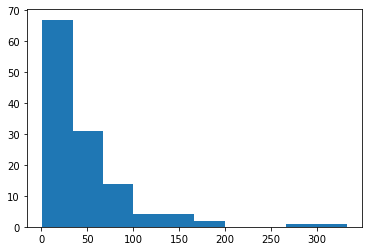

In [26]:
plt.hist(df.groupby('actor').count())